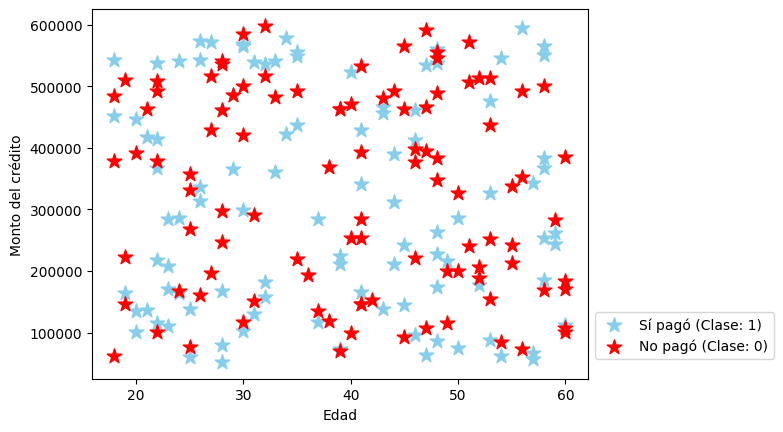

Clase: 1
Probabilidades por clase: 1.0 0.0


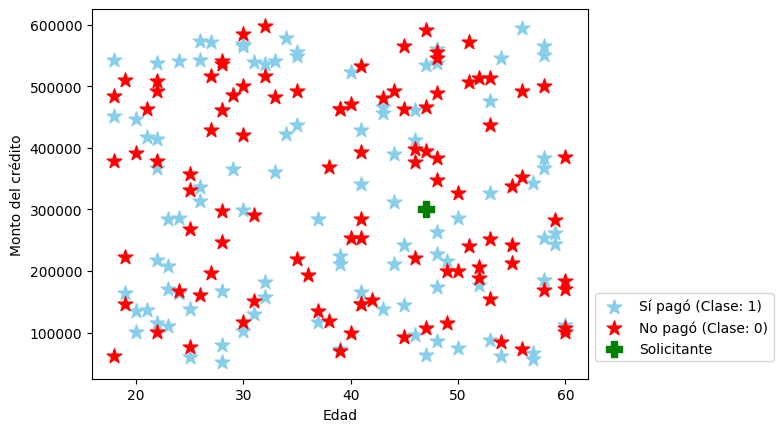

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Leer la base de datos
clients = pd.read_csv("./Assets/dataBaseElements200.csv")

# Filtrar clientes buenos y malos (clientes pagadores vs clientes deudores)
goodCustomers = clients[clients["Cumplio"] == 1]
badCustomers = clients[clients["Cumplio"] == 0]

# Grafico de dispersión de clientes buenos y malos (clientes pagadores vs clientes deudores)
plt.scatter(goodCustomers["Edad"], goodCustomers["Credito"],
            marker="*", s=120, color="skyblue", label="Sí pagó (Clase: 1)")

plt.scatter(badCustomers["Edad"], badCustomers["Credito"],
            marker="*", s=120, color="red", label="No pagó (Clase: 0)")

plt.ylabel("Monto del crédito")
plt.xlabel("Edad")
plt.legend(bbox_to_anchor=(1, 0.2))
plt.show()

# Preparar los datos
dataClients = clients[["Edad", "Credito"]].values
classClient = clients["Cumplio"].values

# Escalar los datos (escalar los datos para que estén en el rango [0, 1]. Esto es importante para que las diferentes características tengan la misma importancia en el cálculo de la distancia)
dataScaled = (dataClients - dataClients.min(axis=0)) / (dataClients.max(axis=0) - dataClients.min(axis=0))

# Implementación del KD-Tree y KNN
# Definir una estructura de datos llamada KDNode para representar nodos en el KD-Tree. Luego, implementamos las funciones build_kdtree y knn_search para construir el KD-Tree y buscar vecinos cercanos en él, respectivamente. 
class KDNode:
    def __init__(self, point, axis, left=None, right=None):
        self.point = point # El punto de datos que este nodo representa
        self.axis = axis #  El eje a lo largo del cual se realizará la división en el árbol
        self.left = left # Referencia al nodo hijo izquierdo
        self.right = right # Referencia al nodo hijo derecho

# Definir una función build_kdtree que construye el KD-Tree recursivamente. El KD-Tree divide los datos en cada nivel a lo largo de un eje específico y construye subárboles en función de los valores medianos de los datos.
def build_kdtree(points, depth=0):
    if len(points) == 0:
        # Si no hay puntos, retorna None, lo cual indica que este es un nodo hoja vacío
        return None
    # Calcula el eje actual de división usando depth % len(points[0]). depth es la profundidad actual en el árbol y se alterna entre los ejes.
    # Ordena los puntos a lo largo del eje actual.
    # Encuentra el punto mediano y crea un nodo KDNode con ese punto y eje.
    # Recursivamente construye el subárbol izquierdo con los puntos antes del mediano y el subárbol derecho con los puntos después del mediano.
    axis = depth % len(points[0])
    points = points.tolist()
    points.sort(key=lambda point: point[axis])
    median = len(points) // 2
    return KDNode(np.array(points[median]), axis,
                  build_kdtree(np.array(points[:median]), depth + 1),
                  build_kdtree(np.array(points[median + 1:]), depth + 1))

# Definir una función knn_search que realiza una búsqueda de k vecinos más cercanos en el KD-Tree. Utiliza una búsqueda recursiva para encontrar los vecinos más cercanos.
def knn_search(node, point, k=1):
    def recursive_search(node, point, k, nearest):
        if node is None:
            return
        distance = np.linalg.norm(point - node.point)
        if len(nearest) < k:
            nearest.append((distance, node.point))
            nearest.sort(key=lambda x: x[0])
        elif distance < nearest[-1][0]:
            nearest.pop()
            nearest.append((distance, node.point))
            nearest.sort(key=lambda x: x[0])
        
        axis_distance = point[node.axis] - node.point[node.axis]
        closer_node, farther_node = (node.left, node.right) if axis_distance <= 0 else (node.right, node.left)
        
        recursive_search(closer_node, point, k, nearest)
        if abs(axis_distance) < nearest[-1][0]:
            recursive_search(farther_node, point, k, nearest)
    
    nearest_points = []
    recursive_search(node, point, k, nearest_points)
    return [point for _, point in nearest_points]

# Construir el KD-Tree utilizando los datos escalados. El KD-Tree es una estructura que organiza los datos de manera que las búsquedas de vecinos cercanos sean más eficientes
kdtree = build_kdtree(dataScaled)

# Datos del nuevo solicitante y los escalamos de manera similar a los datos originales
ageApplicant = 47
creditApplicant = 300000
applicant = np.array([ageApplicant, creditApplicant])
applicant_scaled = (applicant - dataClients.min(axis=0)) / (dataClients.max(axis=0) - dataClients.min(axis=0))

# Realizar la búsqueda KNN en el KD-Tree para el nuevo solicitante
k = 3
nearest_neighbors = knn_search(kdtree, applicant_scaled, k)

# Obtener los índices de los vecinos más cercanos en los datos escalados y calculamos la clase y las probabilidades para el nuevo solicitante
nearest_indices = [np.where((dataScaled == neighbor).all(axis=1))[0][0] for neighbor in nearest_neighbors]
predicted_class = sum(classClient[index] for index in nearest_indices) / k
print("Clase:", round(predicted_class))
print("Probabilidades por clase:", predicted_class, 1 - predicted_class)

# Graficar resultados con el nuevo solicitante
plt.scatter(goodCustomers["Edad"], goodCustomers["Credito"],
            marker="*", s=120, color="skyblue", label="Sí pagó (Clase: 1)")

plt.scatter(badCustomers["Edad"], badCustomers["Credito"],
            marker="*", s=120, color="red", label="No pagó (Clase: 0)")

plt.scatter(ageApplicant, creditApplicant, marker="P", s=120, color="green", label="Solicitante")

plt.ylabel("Monto del crédito")
plt.xlabel("Edad")
plt.legend(bbox_to_anchor=(1, 0.25))
plt.show()
